# A5
https://github.com/joshkmartinez/RL-book/tree/master/A6

# 1
$$
V(t,S_t,W,I)=E[-e^{-\gamma\cdot (W+I\cdot S_T)}|(t,S_t]
\newline
=-e^{-\gamma\cdot W}E[e^{-\gamma I \cdot S_T}|(t,S_t)]
\newline
=-e^{-\gamma\cdot W-\gamma I S_T + \frac{\sigma^2\gamma^2I^2(T-t)}{2}}
\\ \text{Indifference Bid Price} \\
V(t,S_t,W-Q^{(b)}(t,S_t,I),I+1)=V(t,S_t,W,I)
\\
-e^{-\gamma\cdot (W-Q^{b}(t,S_t,I)) -\gamma (I+1) S_T + \frac{\sigma^2\gamma^2I^2(T-t)}{2}} = -e^{-\gamma\cdot W-\gamma I S_T + \frac{\sigma^2\gamma^2I^2(T-t)}{2}}
\\
-\gamma\cdot (W-Q^{b}(t,S_t,I)) -\gamma (I+1) S_T + \frac{\sigma^2\gamma^2I^2(T-t)}{2} = -\gamma\cdot W-\gamma I S_T + \frac{\sigma^2\gamma^2I^2(T-t)}{2}
\\ \text{Indifference Ask Price} \\
V(t,S_t,W+Q^{(b)}(t,S_t,I),I-1)=V(t,S_t,W,I)
\\
-e^{-\gamma\cdot (W+Q^{b}(t,S_t,I)) -\gamma (I-1) S_T + \frac{\sigma^2\gamma^2I^2(T-t)}{2}} = -e^{-\gamma\cdot W-\gamma I S_T + \frac{\sigma^2\gamma^2I^2(T-t)}{2}}
\\
-\gamma\cdot (W+Q^{b}(t,S_t,I)) -\gamma (I-1) S_T + \frac{\sigma^2\gamma^2I^2(T-t)}{2} = -\gamma\cdot W-\gamma I S_T + \frac{\sigma^2\gamma^2I^2(T-t)}{2}
$$

# 2

In [125]:
from dataclasses import dataclass
from rl.distribution import (Constant, Categorical, Uniform, Distribution, FiniteDistribution, Bernoulli, SampledDistribution)
from rl.markov_process import MarkovProcess, State, NonTerminal
from rl.markov_decision_process import MarkovDecisionProcess
from rl.chapter9.order_book import OrderBook, DollarsAndShares
from rl.policy import Policy
from typing import Callable, Sequence, Tuple, Iterator
import numpy as np
import itertools
import matplotlib.pyplot as plt
import copy as cp

In [126]:
@dataclass(frozen=True)
class SharePrice:
    shares: int # continuous time, so always 1 share
    price: float

@dataclass(frozen=True)
class Action:
    bid: SharePrice
    ask: SharePrice
A = Action

class StateMarketMaker:
    mid_price: float = 100
    inv = 0
    PnL: float = 0
    spread: float = 1
S = StateMarketMaker

In [160]:
class OptimalMarketMaker(MarkovDecisionProcess[S, A]):
    # Avallaneda-Stoikov's params
    t = 0.
    T = 1.
    d_t = 0.005
    γ = 0.1
    σ = 2.
    k = 1.5
    c = 140
    
    def step(
        self,
        state: NonTerminal[S],
        action: A
    ) -> SampledDistribution[Tuple[State[S], float]]:
        
        p_a: float = self.c * np.exp(-self.k * float(((1 - 2 * state.state.inv) * self.γ * self.σ**2 * (self.T - self.t) / 2) + 1 / self.γ * np.log(1 + self.γ/self.k))) * self.d_t
        p_b: float = self.c * np.exp(-self.k * float(((2 * state.state.inv + 1) * self.γ * self.σ**2 * (self.T - self.t) / 2) + 1 / self.γ * np.log(1 + self.γ/self.k))) * self.d_t

        def sr_sampler_func(
            state = state,
            action = action,
            p_a = p_a,
            p_b = p_b
        ) -> Tuple[State[S], float]:
            
            next_state = cp.deepcopy(state.state)
            next_state.inv = state.state.inv
            next_state.PnL = state.state.PnL
            next_state.mid_price = state.state.mid_price
            next_state.spread = action.ask.price - action.bid.price # or bid-ask?

            if Bernoulli(0.5).sample(): # update mid price
                next_state.mid_price += self.σ * np.sqrt(self.d_t)
            else:
                next_state.mid_price -= self.σ * np.sqrt(self.d_t)
            
            if Bernoulli(p_b).sample():
                next_state.inv += 1 # inv up
                next_state.PnL -= action.bid.price # pnl decrease
            if Bernoulli(p_a).sample():
                next_state.inv -= 1 #inv down
                next_state.PnL += action.ask.price # pnl increase

            return (NonTerminal(next_state), next_state.PnL)
        
        self.t += self.d_t
        return SampledDistribution(sr_sampler_func)

    def actions(self, state : NonTerminal[S]) -> Iterator[A]:
        
        action = Action(bid=SharePrice(price = float(state.state.mid_price - (2 * state.state.I - 1) - self.γ * self.σ**2 * (self.T - self.t) / 2) - 1 / self.γ * np.log(1 + self.γ/self.k), shares = 1), 
                        ask=SharePrice(price = float(state.state.mid_price - (2 * state.state.I - 1) + self.γ * self.σ**2 * (self.T - self.t) / 2) + 1 / self.γ * np.log(1 + self.γ/self.k)), shares = 1)

        return iter([action])

In [161]:
class OptimalPolicy(Policy):
    T = 1.
    d_t = 0.005
    t = 0.
    γ = 0.1
    σ = 2
    k = 1.5
    def act(self, state: NonTerminal[S]) -> Distribution[A]:
        action = MarketAction(bid=PriceAndShares(price = float(state.state.mid_price - (2 * state.state.inv - 1) - self.γ * self.σ**2 * (self.T - self.t) / 2) - 1 / self.γ * np.log(1 + self.γ/self.k), shares = 1), 
                                 ask=PriceAndShares(price = float(state.state.mid_price - (2 * state.state.inv - 1) + self.γ * self.σ**2 * (self.T - self.t) / 2) + 1 / self.γ * np.log(1 + self.γ/self.k), shares = 1))
        
        return Constant(action)

In [162]:
class NaiveMarketMaker(MarkovDecisionProcess[S, A]):
    inv = 0
    spread: float
    # Avallaneda-Stoikov's params
    t = 0.
    T = 1.
    d_t = 0.005
    γ = 0.1
    σ = 2.
    k = 1.5
    c = 140
    
    def step(
        self,
        state: NonTerminal[S],
        action: A
    ) -> SampledDistribution[Tuple[State[S], float]]:
        
        p_a: float = self.c * np.exp(-self.k * float(((1 - 2 * state.state.inv) * self.γ * self.σ**2 * (self.T - self.t) / 2) + 1 / self.γ * np.log(1 + self.γ/self.k))) * self.d_t
        p_b: float = self.c * np.exp(-self.k * float(((2 * state.state.inv + 1) * self.γ * self.σ**2 * (self.T - self.t) / 2) + 1 / self.γ * np.log(1 + self.γ/self.k))) * self.d_t

        def sr_sampler_func(
            state = state,
            action = action,
            p_a = p_a,
            p_b = p_b
        ) -> Tuple[State[S], float]:
            
            next_state = cp.deepcopy(state.state)
            next_state.inv = state.state.inv
            next_state.PnL = state.state.PnL
            next_state.mid_price = state.state.mid_price
            next_state.spread = action.ask.price - action.bid.price # or bid-ask?

            if Bernoulli(0.5).sample(): # update mid price
                next_state.mid_price += self.σ * np.sqrt(self.d_t)
            else:
                next_state.mid_price -= self.σ * np.sqrt(self.d_t)
            
            if Bernoulli(p_b).sample():
                next_state.inv += 1 # inv up
                next_state.PnL -= action.bid.price # pnl decrease
            if Bernoulli(p_a).sample():
                next_state.inv -= 1 #inv down
                next_state.PnL += action.ask.price # pnl increase

            return (NonTerminal(next_state), next_state.PnL)
        
        self.t += self.d_t
        return SampledDistribution(sr_sampler_func)

    def actions(self, state : NonTerminal[S]) -> Iterator[A]:
        action: A = MarketAction(bid=PriceAndShares(price = float(state.state.mid_price - self.spread/2), shares = 1), 
                                 ask=PriceAndShares(price = float(state.state.mid_price + self.spread/2), shares = 1))

        return iter([action])

In [163]:
class NaivePolicy(Policy):
    T = 1.
    d_t = 0.005
    t = 0.
    γ = 0.1
    σ = 2
    k = 1.5
    spread = 1.

    def act(self, state: NonTerminal[S]) -> Distribution[A]:
        action = MarketAction(bid=PriceAndShares(price = float(state.state.mid_price - self.spread / 2), shares = 1), 
                                 ask=PriceAndShares(price = float(state.state.mid_price + self.spread / 2), shares = 1))
        
        return Constant(action)

<ipython-input-160-9469064dd6ea>:17: RuntimeWarning: overflow encountered in double_scalars
  p_a: float = self.c * np.exp(-self.k * float(((1 - 2 * state.state.inv) * self.γ * self.σ**2 * (self.T - self.t) / 2) + 1 / self.γ * np.log(1 + self.γ/self.k))) * self.d_t
<ipython-input-160-9469064dd6ea>:17: RuntimeWarning: overflow encountered in exp
  p_a: float = self.c * np.exp(-self.k * float(((1 - 2 * state.state.inv) * self.γ * self.σ**2 * (self.T - self.t) / 2) + 1 / self.γ * np.log(1 + self.γ/self.k))) * self.d_t
<ipython-input-160-9469064dd6ea>:18: RuntimeWarning: overflow encountered in double_scalars
  p_b: float = self.c * np.exp(-self.k * float(((2 * state.state.inv + 1) * self.γ * self.σ**2 * (self.T - self.t) / 2) + 1 / self.γ * np.log(1 + self.γ/self.k))) * self.d_t
<ipython-input-160-9469064dd6ea>:18: RuntimeWarning: overflow encountered in exp
  p_b: float = self.c * np.exp(-self.k * float(((2 * state.state.inv + 1) * self.γ * self.σ**2 * (self.T - self.t) / 2) + 1 / self.γ

Text(0.5, 1.0, 'Samples of Optimal (green) vs Naive (blue) Mid Price (bid-ask)')

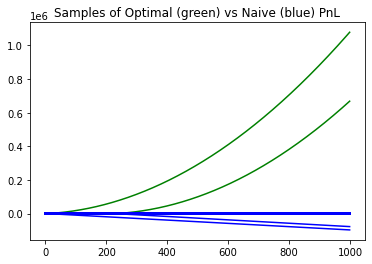

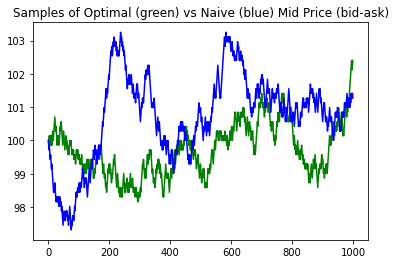

In [164]:
traces = 1000

optimal_samples = [list(itertools.islice(generator, traces))
           for generator
           in list(itertools.islice(OptimalMarketMaker().action_traces(Constant(NonTerminal(StateMarketMaker())), OptimalPolicy()), traces))]

for PnL in [[step.state.state.PnL for step in sample_path] for sample_path in optimal_samples]: # Optimal PnL traces
    plt.plot(PnL, color="green")

naive_policy.spread = float(np.mean([np.mean(spread)
                                     for spread
                                     in [[step.state.state.spread for step in sample_path] for sample_path in optimal_samples]]))

naive_samples = [list(itertools.islice(generator, traces))
           for generator
           in list(itertools.islice(NaiveMarketMaker().action_traces(Constant(NonTerminal(StateMarketMaker())), NaivePolicy()), traces))]

for PnL in [[step.state.state.PnL for step in sample_path] for sample_path in naive_samples]: # Naive PnL Traces
    plt.plot(PnL, color="blue")

plt.title("Samples of Optimal (green) vs Naive (blue) PnL")
plt.figure().clear()

# mid = bid - ask
plt.plot([step.state.state.mid_price for step in optimal_samples[0]], color = "green") # optimal mid prices
plt.plot([step.state.state.mid_price for step in naive_samples[0]], color = "blue") # naive mid prices
plt.title("Samples of Optimal (green) vs Naive (blue) Mid Price (bid-ask)")

# 3

In [205]:
import itertools
from typing import Iterator, TypeVar, Callable, Iterable, Mapping
from rl.distribution import Choose
from rl.markov_process import NonTerminal, State, ReturnStep, TransitionStep
from rl.returns import returns
from rl.function_approx import learning_rate_schedule
from rl.chapter2.simple_inventory_mrp import SimpleInventoryMRPFinite
from rl.chapter10.prediction_utils import fmrp_episodes_stream, unit_experiences_from_episodes
import rl.iterate as iterate
from pprint import pprint

S = TypeVar("S")
TabularValueFunctionApprox = Mapping[NonTerminal[S], float]

In [221]:
def tabular_MC_update(
        v_f: TabularValueFunctionApprox,
        counts: Mapping[NonTerminal[S], int],
        steps: Iterable[ReturnStep[S]],
        weight: Callable[[int], float]
):
    for i in steps:
        counts[i.state] += 1
        v_f[i.state] += weight(counts[i.state]) * (i.return_ - v_f[i.state])


def tabular_MC(
        traces: Iterable[Iterable[TransitionStep]],
        approx_0: TabularValueFunctionApprox,
        gamma: float,
        episode_length_tolerance: float = 1e-6
) -> Iterator[TabularValueFunctionApprox[S]]:
    episodes: Iterator[Iterator[ReturnStep[S]]] = (returns(trace, gamma, episode_length_tolerance) for trace in traces)
    f = approx_0
    counts: Mapping[NonTerminal[S], int] = {s: 0 for s in f.keys()}
    
    yield f
    for i in episodes:
        tabular_mc_update(f, counts, i, lambda l: 1.0 / l)
        yield f


In [222]:
def tabular_TD_update(
        v: TabularValueFunctionApprox[S],
        counts: Mapping[NonTerminal[S], int],
        transition: TransitionStep[S],
        gamma: float,
        learning_rate: Callable[[int], float]
):
    counts[transition.state] += 1
    v[transition.state] += learning_rate(counts[transition.state]) * (transition.reward + gamma * extended_vf(v, transition.next_state) - v[transition.state])
    return v, counts


def tabular_TD(
        transitions: Iterable[TransitionStep],
        approx_0: TabularValueFunctionApprox,
        gamma: float,
        learning_rate: Callable[[int], float]
) -> Iterator[TabularValueFunctionApprox[S]]:
    f = approx_0
    counts = {s: 0 for s in f.keys()}
    # iterator
    yield f

    for i in transitions:
        tabular_td_update(f, counts, i, gamma, learning_rate)
        yield f


In [223]:
# Extended value function
def ex_v_f(v_f: TabularValueFunctionApprox[NonTerminal[S]], state: State[S]) -> float:
    return state.on_non_terminal(lambda l: v_f[l], 0.)

In [239]:
traces = 500

InventoryMRP = SimpleInventoryMRPFinite(
    capacity = 2,
    poisson_lambda = 1,
    holding_cost = 1,
    stockout_cost = 10
)
    
approx_0 = {i: 0.5 for i in InventoryMRP.non_terminal_states}
episodes = fmrp_episodes_stream(InventoryMRP)


print("MC")
mc_v_f = tabular_MC(
        traces = episodes,
        approx_0 = approx_0,
        gamma = 0.9
    )
v_f = iterate.last(itertools.islice(mc_v_f, traces))
pprint({i: round(v_f[i], 6) for i in InventoryMRP.non_terminal_states})


print("TD")
TD_len = int(round(sum(len(list(returns(
    trace = InventoryMRP.simulate_reward(Choose(InventoryMRP.non_terminal_states)),
    γ = 0.9,
    tolerance = 1e-6
))) for i in range(traces)) / traces))

TD_v_f = tabular_TD(
    unit_experiences_from_episodes(episodes, TD_len),
    approx_0 = approx_0,
    gamma = 0.9,
    learning_rate = learning_rate_schedule(0.05, 500, 0.3)
)
v_f = iterate.last(itertools.islice(TD_v_f, traces * TD_len))
pprint({i: round(v_f[i],6) for i in InventoryMRP.non_terminal_states})


print("MRP v_f")
InventoryMRP.display_value_function(gamma = 0.9)

MC
{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.747948,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -28.17215,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -30.591503,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.624971,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -29.174665,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -28.618557}
TD
{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.91237,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -28.156545,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -30.2565,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.12745,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.973353,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -28.536343}
MRP v_f
{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.511,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.932,
 No